In [1]:

from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn import ensemble
from sklearn.svm import NuSVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import time
from numba import prange
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
MODELS = {DecisionTreeRegressor, ensemble.ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, NuSVR, ExtraTreeRegressor,
          LinearRegression, BayesianRidge, KNeighborsRegressor, XGBRegressor, XGBRFRegressor, MLPRegressor, LassoLarsIC,
          ElasticNet, SGDRegressor, LassoLars, Lasso, LinearSVR, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor}


In [3]:
housing = pd.read_csv(r'./datasets/kc_house_data.csv')
quality = pd.read_csv(r'./datasets/winequality-red.csv')


In [4]:
housing


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
quality


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [6]:
housing = housing.dropna()
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
quality.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
def metrics(tt, tp, vt, vp, model,
            time=None): return {
    "model": model,
    'time': time,
    "mse": (mean_squared_error(tt, tp),
            mean_squared_error(vt, vp)),
    'r2': (r2_score(tt, tp),
           r2_score(vt, vp))
}


def create_model(X, y, model_name,
                 time_it: bool = False):
    model = model_name()
    if time_it == True:
        begin = time.perf_counter()
        model.fit(X, y)
        end = time.perf_counter()
        return (model, end - begin)
    return model.fit(X, y)


def get_metrics(model_name):
    Xt, Xv, yt, yv = train_test_split(
        housing_X, housing_y, train_size=.7)
    results = create_model(Xt, yt, model_name, time_it=True)
    model, time = results[0], results[1]
    return metrics(
        yt, model.predict(Xt), yv,
        model.predict(Xv), model_name, time)


def get_results(X, y, models):
    results = []
    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        res = executor.map(get_metrics, models)
        results = [i for i in res if i]
    return results


def plot_results(results: 'list[dict]'):
    y = [i['model'] for i in results]
    pos = np.arange(len(y))
    plt.barh(pos, [i['mse'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Validation')
    plt.show()
    plt.barh(pos, [i['mse'][0] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Traning')
    plt.show()
    plt.barh(pos, [i['time'] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Time')
    plt.show()
    plt.barh(pos, [i['r2'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('R2')
    plt.show()
    plt.barh(pos, [i['time'] * i['mse'][1] * -
             1 for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Efficiency (Higher the better)')
    plt.show()
    plt.barh(pos, [-1 * i['time'] * i['mse'][1] / (i['mse']
             [1] - i['mse'][0]) for i in results], align='center')
    plt.yticks(pos, y)
    plt.title('Weighted Efficiency (Higher the better)')
    plt.show()


In [9]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [10]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [11]:
housing_y


0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64

In [12]:
housing_X = MinMaxScaler().fit_transform(
    RobustScaler().fit_transform(housing_X))


In [13]:
housing_results = get_results(
    housing_X, housing_y, MODELS)


c:\Users\Admin\Desktop\aitfdl\variational-gradient-boosting\env\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\Admin\Desktop\aitfdl\variational-gradient-boosting\env\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.


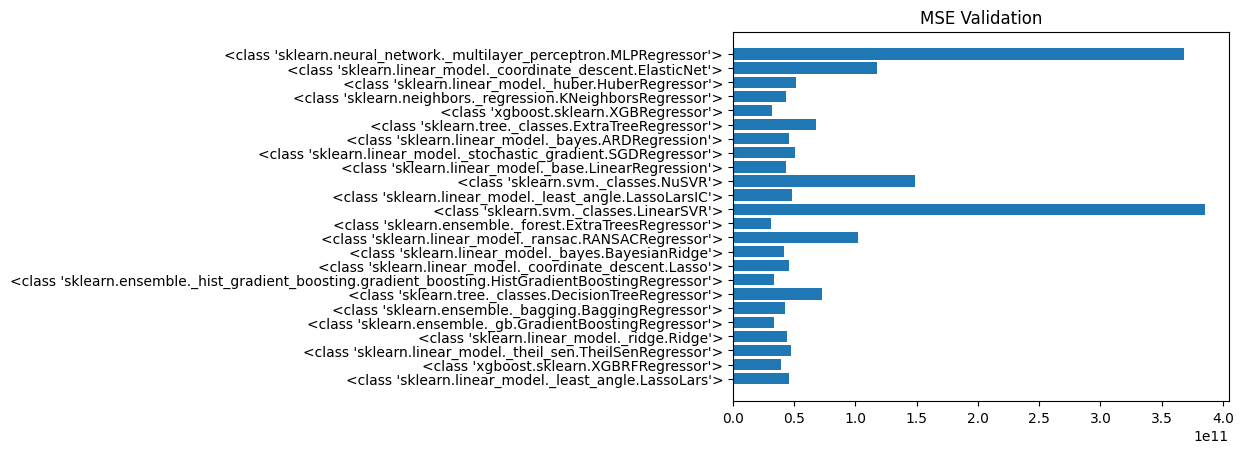

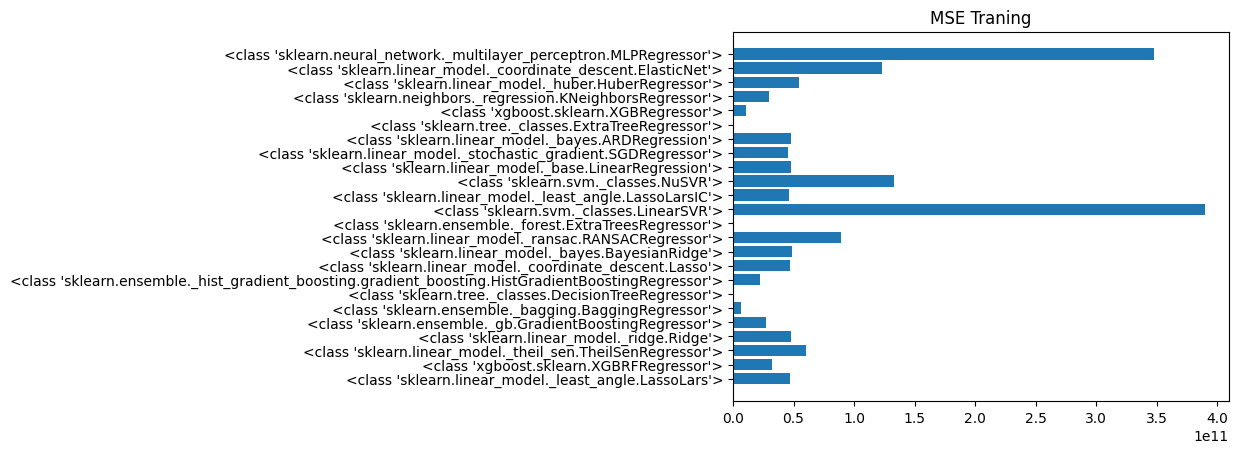

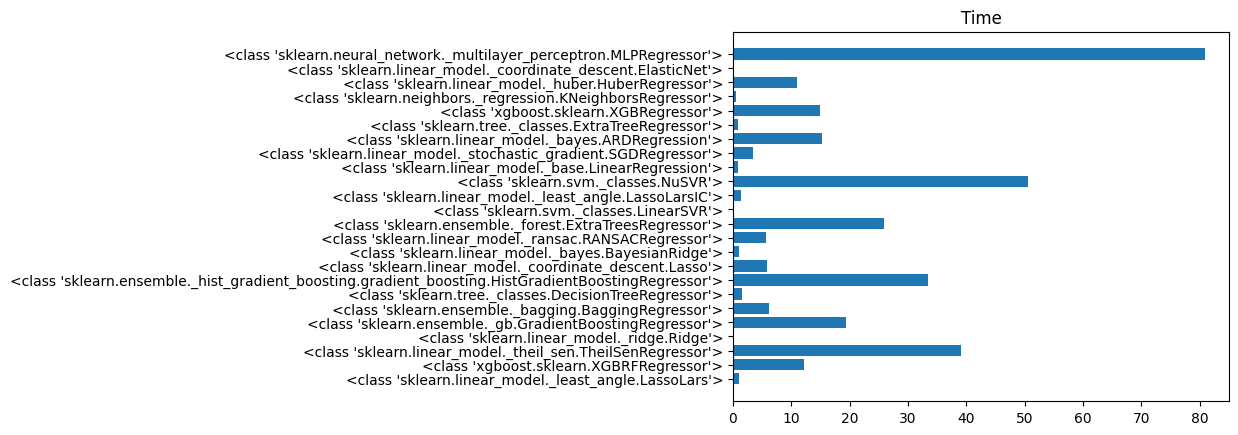

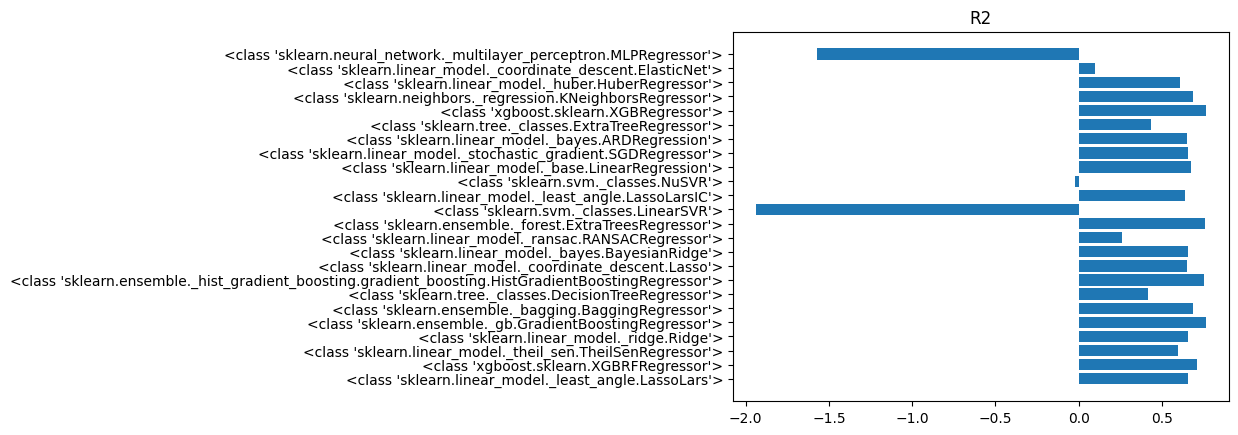

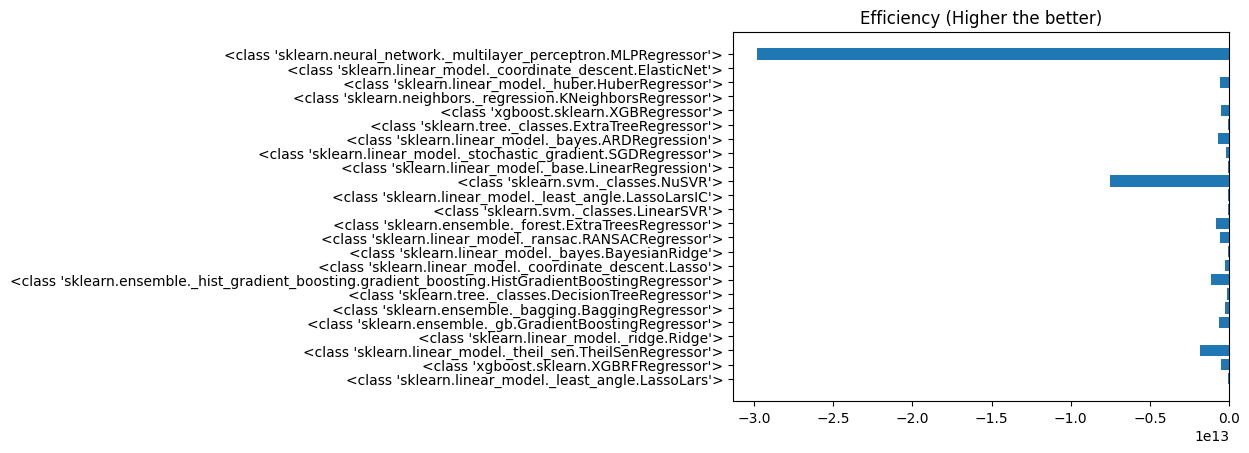

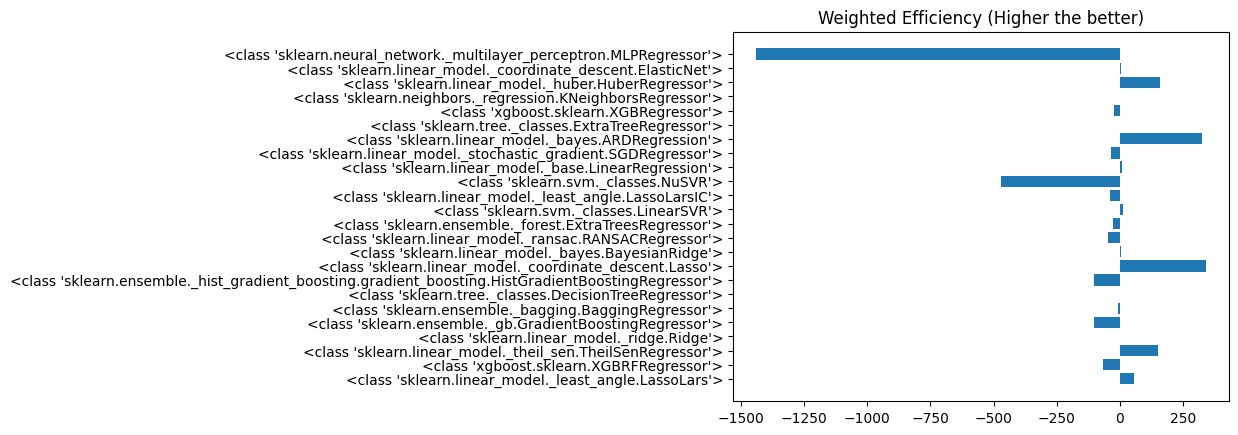

In [14]:
plot_results(housing_results)


In [15]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [71]:
from VGBoost import VGBRegressor


In [81]:
models = VGBRegressor()


In [82]:
import warnings
warnings.filterwarnings("ignore")


In [84]:
models = models.fit(quality_X, quality_y,)


In [85]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

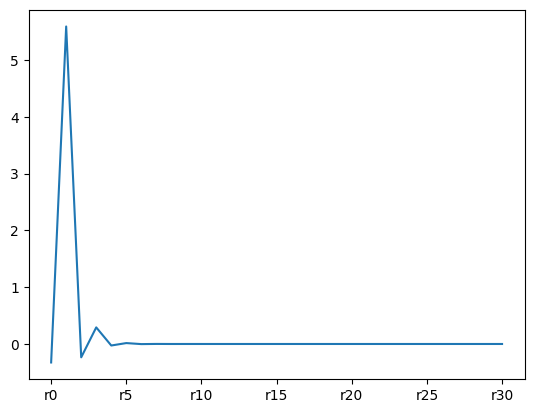

In [86]:
res.mean().plot()


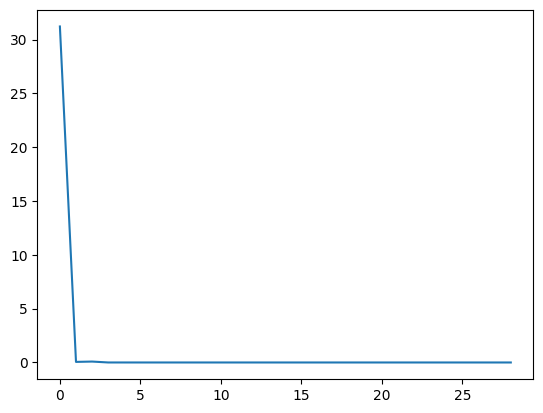

In [87]:
plt.plot(errors)


In [88]:
errors, models


([31.221033457560836,
  0.053770262071847985,
  0.08518591848173701,
  0.0007091855075441331,
  0.0002538359723079096,
  4.5387277587892115e-06,
  8.154722534493919e-07,
  2.299534744258759e-08,
  2.7803087033727457e-09,
  1.0439621355822082e-10,
  9.905524163036828e-12,
  4.465885184603587e-13,
  3.6397720615773294e-14,
  1.8426809795048446e-15,
  1.3668136865197312e-16,
  7.469080866490177e-18,
  5.200433532637408e-19,
  2.9823913274939444e-20,
  1.997290779953948e-21,
  1.1814662204211346e-22,
  7.718518019269984e-24,
  4.652928846948519e-25,
  2.969647143848208e-26,
  1.8175355256292112e-27,
  1.1391627550674423e-28,
  7.055346970335016e-30,
  7.762805718356861e-31,
  2.587601906118954e-31,
  2.587601906118954e-31],
 [BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  BaggingR

In [89]:
/len errors


29

In [90]:
models = VGBRegressor()
models = models.fit(quality_X, quality_y, complexity=True,)


In [91]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

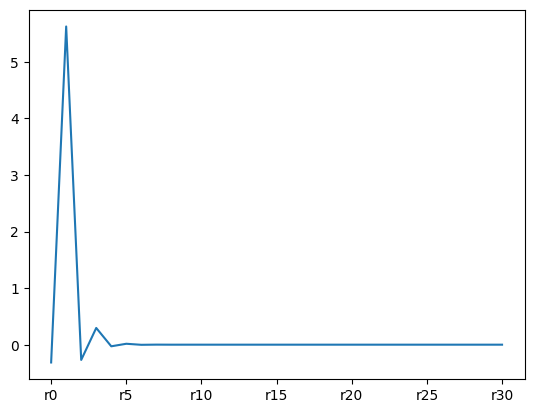

In [92]:
res.mean().plot()


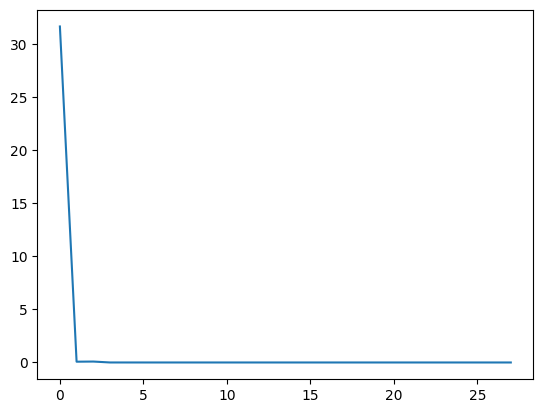

In [93]:
plt.plot(errors)


In [94]:
errors, models


([31.639126567908587,
  0.07320250433141724,
  0.08736442717424617,
  0.000825203986219568,
  0.0002637445414947374,
  5.093303755454793e-06,
  8.557197868324681e-07,
  2.5327863973603197e-08,
  2.9387277085096697e-09,
  1.138055647403472e-10,
  1.0522837939217941e-11,
  4.838441100554126e-13,
  3.8798596010286225e-14,
  1.991665737535629e-15,
  1.459278660853218e-16,
  8.039451241080853e-18,
  5.561715816531092e-19,
  3.2061681863907945e-20,
  2.138271166443664e-21,
  1.2690258421919225e-22,
  8.268335807635061e-24,
  4.998587317943014e-25,
  3.211145032666866e-26,
  1.9719804551661984e-27,
  1.3290887882053155e-28,
  1.2445649816141629e-29,
  3.090198558522897e-30,
  8.864201572581945e-31],
 [ExtraTreesRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  GradientBoostingRegressor(),
  GradientBoostingRegressor(),
  GradientBoostingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  HistGradientBoostingRegressor(),

In [96]:
/len errors


28

In [97]:
models = VGBRegressor()  # 19.6


In [98]:
models = models.fit(housing_X, housing_y,)


In [99]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

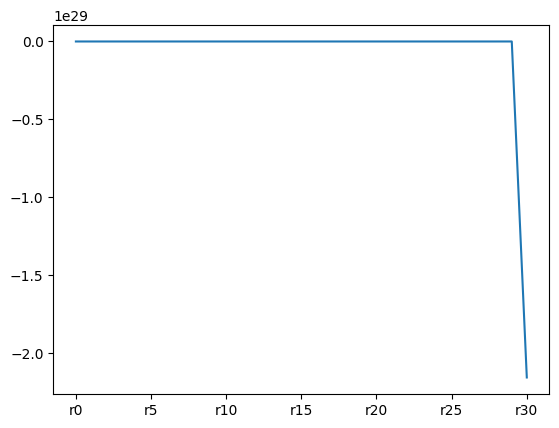

In [100]:
res.mean().plot()


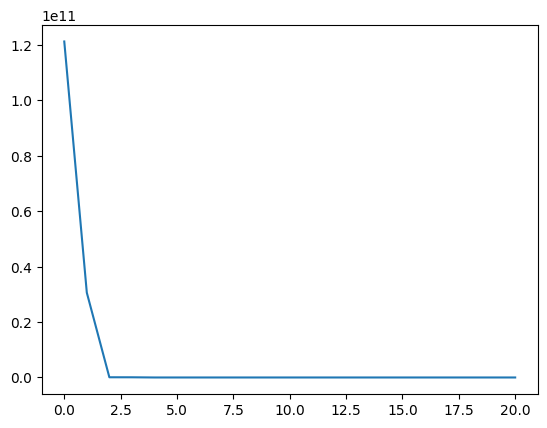

In [101]:
plt.plot(errors)


In [102]:
errors, models


([121141944734.38412,
  30578698215.182217,
  75580004.00147943,
  69101384.10578355,
  3574.4582607537204,
  172131.39755871295,
  408.6090360048049,
  472.85220403594803,
  4.380808941814878,
  1.4201526823235626,
  0.02695151464770567,
  0.0045952424170640814,
  0.00013447913192638882,
  1.5753809989895475e-05,
  6.056755171351152e-07,
  5.6342403220388386e-08,
  2.5786214423504607e-09,
  2.0756685851590422e-10,
  1.0623298463677015e-11,
  7.802534392024062e-13,
  4.477368289954768e-14],
 [BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRe

In [103]:
/len errors


21

In [104]:
models = VGBRegressor()  # 19.6


In [105]:
models = models.fit(housing_X, housing_y, complexity=True)


In [106]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

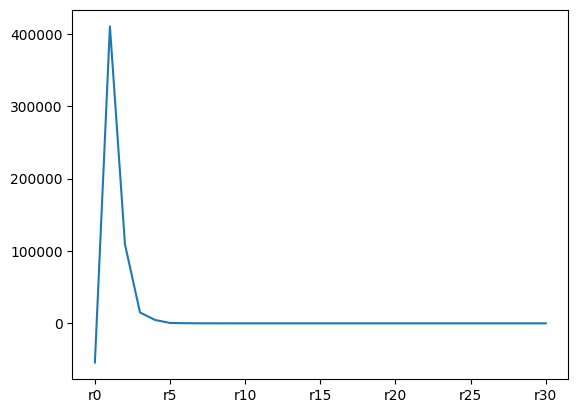

In [107]:
res.mean().plot()


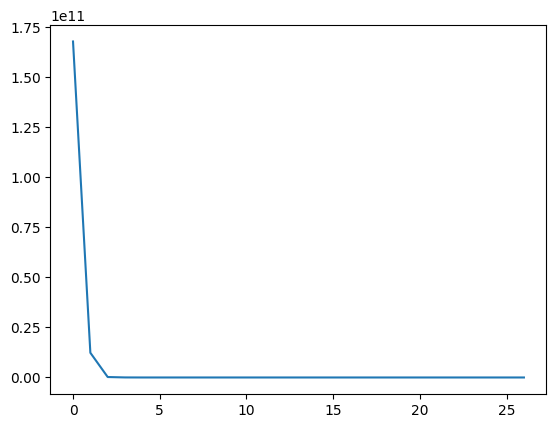

In [108]:
plt.plot(errors)


In [110]:
errors, models


([167666163639.03094,
  12330220212.42668,
  224949820.28721496,
  23220397.650765907,
  268208.1256185126,
  46915.7428914978,
  264.5730505600662,
  103.51756893527845,
  0.26484736099489886,
  0.25255969668597306,
  0.0010149031310200713,
  0.0006831404109319011,
  6.958029152093236e-06,
  2.031704538497198e-06,
  3.953297460063396e-08,
  6.539064071436837e-09,
  1.9309732783644638e-10,
  2.236158394121722e-11,
  8.634602550227171e-13,
  7.988895461157935e-14,
  3.6565606492891285e-15,
  2.9160677582065526e-16,
  1.377476906672364e-17,
  8.569194693342438e-19,
  4.119538840740662e-20,
  2.0451085941242757e-21,
  1.959545059117893e-26],
 [HistGradientBoostingRegressor(),
  GradientBoostingRegressor(),
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',

In [111]:
/len errors


27